# MILP optimization control with deep network transition

## Simple planning problem with continuous states
In this simple planning problem, we are going to show learning the model directly from realtime data stream and apply optimization on the model. The data will be generated from a simulator, which represent a 2D maze problem. 

Package installation

In [2]:
!pip --quiet install keras
!pip --quiet install h5py
!pip --quiet install shapely
!pip --quiet install descartes

Package imports

In [83]:
%matplotlib inline
import random
import os
import json
import sys
import string
import unicodedata
from tqdm import tqdm
#Numpy and Scipy
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from scipy.spatial import distance
#KERAS
from keras.layers import Dense, Activation,Dropout
from keras.models import Sequential
from keras.regularizers import l1,l2
from keras.models import load_model

#### Supporting Functions

In [7]:
#Given local path, find full path
def PathFinder(path):
    script_dir = os.path.dirname('__file__')
    fullpath = os.path.join(script_dir,path)
    return fullpath

#Read Data for Deep Learning
def ReadData(path):
    fullpath=PathFinder(path)
    return genfromtxt(fullpath, delimiter=',')

## Data Generation Part
### 1. Maze problem domain simulator

Brief Discription of this domain simulator

1. Define a 2D maze, which allows agent move continously in this domain. 
2. Has one Goal state and one start state. 
3. Allows to define obstacles that agent cannot move in, or it will transfered to jail.
4. There is a jail location that outside maze domain.
5. Agent alive in deadend in the period of tolerate time steps


In [8]:
'''
Created on Oct 20, 2016

This class has two construction functions.
1. From data
2. From initial settings

Example of 2D maze setting

initial_setting = {
    "maze"        : (0,0,10,10),                    #Continous state bound
    "start_state"     : (0,0),                          #Current State in X,Y and If in Jail
    "action_range"      : (-0.5,0.5),                     #The effective action range
    "goal_states"        : [(10,10)],                      #The goal state to finish running
    "jail_location"     : (-1,-1),                        #Jail location
    "obstacles"   : [[(1,1),(1,3),(3,3),(3,1)]],    #Some obstacles that never crosspassing
    "muds"     : [[(0,5),(5,5),(5,10),(0,10)]],  #Mud area where movement is halfed
    "deadend_toleration": 2                               #How many step left after getting into jail
                   }
@author: wuga
'''

#SHAPELY
from shapely.geometry import Point
from shapely.geometry import MultiPoint
from shapely.geometry import LineString
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.geometry.polygon import LinearRing
from descartes.patch import PolygonPatch

COLOR = {
    True:  '#6699cc',
    False: '#ff3333'
    }

class DeterministicMazeRemaster(object):
    
    def __init__(self, setting):
        maze=setting.get('maze')
        self.maze=box(maze[0],maze[1],maze[2],maze[3])
        obstacles=setting.get('obstacles')
        self.obstacles=[]
        if obstacles:
            for coord in obstacles:
                self.obstacles.append(Polygon(coord))
        
        muds=setting.get('muds')
        self.muds=[]
        if muds:
            for coord in muds:
                self.muds.append(Polygon(coord))
        start_state=setting.get('start_state')
        self.start_state=Point(start_state)
        self.current_state=self.start_state
        goal_states=setting.get('goal_states')
        self.goal_states=[]
        for coord in goal_states:
            self.goal_states.append(Point(coord))
        self.action_range=setting.get('action_range')
        self.deadend_toleration=setting.get('deadend_toleration')
        self.injail=False
        self.inmud=False
        self.backup = {k:v for k, v in self.__dict__.items() if not (k.startswith('__') and k.endswith('__'))}
        
    def PlotMaze(self):
        fig = plt.figure(dpi=90)
        ax = fig.add_subplot(111)
        x, y = self.maze.exterior.xy
        ax.plot(x, y, 'o', color='#999999', zorder=1)
        patch = PolygonPatch(self.maze, facecolor='#6699cc', edgecolor='#6699cc', alpha=0.5, zorder=2)
        ax.add_patch(patch)
        if self.muds:
            for mud in self.muds:
                patch = PolygonPatch(mud, facecolor='#ff3333', edgecolor='#ff3333', alpha=0.5,hatch='\\', zorder=2)
                ax.add_patch(patch)
        if self.obstacles:
            for obstacles in self.obstacles:
                patch = PolygonPatch(obstacles, facecolor='#ffaabb', edgecolor='#ffaabb', alpha=0.5,hatch='\\', zorder=2)
                ax.add_patch(patch)
        plt.show()
        
    def Reset(self):
        backup=self.backup
        self.__dict__.update(backup)
        self.backup = backup
    
    def UpdateState(self,new_state):
        self.current_state = new_state
        
    def InJail(self):
        return int(self.injail)
    
    def InMud(self):
        for mud in self.muds:
            if mud.intersects(self.current_state):
                self.Inmud=True
            else:
                self.Inmud=False
        return int(self.Inmud)
    
    def GetCurrentState(self):
        return self.current_state.x, self.current_state.y, self.InJail(),self.InMud()
        
    def TakeAction(self,action):
        if not self.injail:
            proposal=Point((self.current_state.x+action[0],self.current_state.y+action[1]))
            #print proposal.x, proposal.y
            path=LineString([self.current_state, proposal])
            
            if self.obstacles:
                for obstacle in self.obstacles:
                    if obstacle.intersects(path):
                        self.injail=True
                        self.current_state=Point((-1,-1))
                        return
            if self.muds:
                for mud in self.muds:
                    if mud.intersects(path):
#                         print 'we are here'
                        path_inmud = mud.intersection(path)
                        coords = [path.coords[0],path.coords[1]]
                        for loc in path_inmud.coords:
                            if loc not in coords:
                                coords.append(loc)
                        coords.sort(key=lambda tup: tup[1]) 
                        p_in_mud=proposal.intersects(mud)
                        s_in_mud=self.current_state.intersects(mud)
                        if p_in_mud and not s_in_mud: 
#                             print 'current not in mud'
                            if coords.index((self.current_state.x,self.current_state.y))==0: 
                                x = coords[1][0]-coords[0][0]+0.5*(coords[-1][0]-coords[1][0])
                                y = coords[1][1]-coords[0][1]+0.5*(coords[-1][1]-coords[1][1])
                                proposal=Point((coords[0][0]+x,coords[0][1]+y))
                            else:
                                x = coords[1][0]-coords[-1][0]+0.5*(coords[0][0]-coords[1][0])
                                y = coords[1][1]-coords[-1][1]+0.5*(coords[0][1]-coords[1][1])
                                proposal=Point((coords[-1][0]+x,coords[-1][1]+y))
                        elif s_in_mud and not p_in_mud:
#                             print 'proposal not in mud'
                            if coords.index((self.current_state.x,self.current_state.y))==0: 
                                x = 0.5*(coords[1][0]-coords[0][0])+(coords[-1][0]-coords[1][0])
                                y = 0.5*(coords[1][1]-coords[0][1])+(coords[-1][1]-coords[1][1])
                                proposal=Point((coords[0][0]+x,coords[0][1]+y))
                            else:
                                x = 0.5*(coords[1][0]-coords[-1][0])+(coords[0][0]-coords[1][0])
                                y = 0.5*(coords[1][1]-coords[-1][1])+(coords[0][1]-coords[1][1])
                                proposal=Point((coords[-1][0]+x,coords[-1][1]+y))
                        else:
                            proposal=Point((self.current_state.x+action[0]*0.5,self.current_state.y+action[1]*0.5))
            
            path=LineString([self.current_state, proposal])
            bounds=LinearRing(self.maze.exterior.coords) 
            if bounds.intersects(path):
                onedge=bounds.intersection(path)
                if  type(onedge) is MultiPoint:
                    for point in onedge:
                        if not point.equals(self.current_state):
                            proposal=point
                elif type(onedge) is Point:
                    if not onedge.equals(self.current_state):
                        proposal=onedge
                    elif not self.maze.contains(proposal):
                        proposal=bounds.interpolate(bounds.project(proposal))
                        
            self.current_state=proposal
        else:
            self.deadend_toleration=self.deadend_toleration-1
        return self.GetCurrentState()
        
    def IfGameEnd(self):
        for goal in self.goal_states:
            if self.current_state.equals(goal):
                self.Reset()
        if (self.deadend_toleration == 0):
            self.Reset()
    
    def DeltaDistance(self,new_state,old_state):
        delta=[]
        delta.append(new_state[0]-old_state[0])
        delta.append(new_state[1]-old_state[1])
        if (new_state[2]==1):
            delta.append(1)
        else:
            delta.append(0)
        if (new_state[3]==1):
            delta.append(1)
        else:
            delta.append(0)
        return delta


#### Simulator Test code
Please read the setting structure for creating maze.

This is an example of defining a maze

### 2. Planner
This planner is a random walker, who will explore the maze randomly. This is just for generate more random data to support transition function training. 

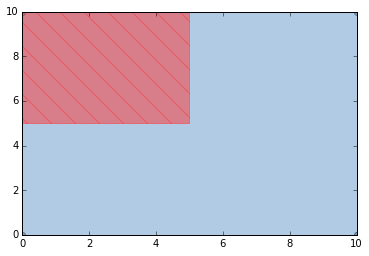

(0.0, 0.0, 0, 0)
(2.0, 10.0, 0, 1)
2
(1.0, 9.0, 0, 1)
2
(2.0, 10.0, 0, 1)
2


In [9]:
initial_setting = {
    "maze"              : (0,0,10,10),                    #Continous state bound
    "start_state"       : (0,0),                          #Current State in X,Y and If in Jail
    "action_range"      : (-0.5,0.5),                     #The effective action range
    "goal_states"       : [(10,10)],                      #The goal state to finish running
    "jail_location"     : (-1,-1),                        #Jail location
    "obstacles"         : [], #[[(5,2),(5,5),(8,5),(8,2)]], Some obstacles that never crosspassing
    "muds"              : [[(0,5),(0,10),(5,10),(5,5)]],  #Mud area where movement is halfed
    "deadend_toleration": 2                               #How many step left after getting into jail
}

Maze=DeterministicMazeRemaster(initial_setting)
Maze.backup
Maze.PlotMaze()
print Maze.GetCurrentState()
Maze.TakeAction([5,25])
print Maze.GetCurrentState()
print Maze.deadend_toleration
Maze.TakeAction([-2,-2])
print Maze.GetCurrentState()
print Maze.deadend_toleration
Maze.TakeAction([2,2])
print Maze.GetCurrentState()
print Maze.deadend_toleration

In [76]:
class RandomWalk(object):
    def __init__(self, ranges):
        self.ranges=ranges
    
    def Go(self,epsilon):
        stride=[]
        for i in range(2):
            if random.uniform(0,1)<epsilon:
                stride.append(random.triangular(self.ranges[0],self.ranges[1], 0.2))
            else:
                stride.append(random.uniform(self.ranges[0],self.ranges[1]))
        return stride
    
    def GoPlus(self, state):
        SampleSet=[]
        z=0
        for i in range(5):
            stride=[] 
            for j in range(2):
                stride.append(random.uniform(self.ranges[0],self.ranges[1]))//2-norm resampling
            value=np.linalg.norm([sum(x) for x in zip(stride, state[:2])])
            z=z+value
            SampleSet.append([stride[0],stride[1],value])
        SampleSet=np.array(SampleSet)
        for i in range(len(SampleSet)):
            SampleSet[i,2]=SampleSet[i,2]/z
        finalsample=np.nonzero(np.random.multinomial(1, SampleSet[:,2], size=1)==1)[1][0]
        return [SampleSet[finalsample,0],SampleSet[finalsample,1]]

In [77]:
Maze=DeterministicMazeRemaster(initial_setting)
Planner=RandomWalk(Maze.action_range)
for i in range(10):
    Planner.Go(0.3)

In [78]:
state=(5,5,0,0)
for i in range(10):
    Planner.GoPlus(state)

### 3. Data writter
This class combine the simulator and planner to generate some routing data from multiple tries. 

In [81]:
class DataGenerator(object):
    def __init__(self, model):
            self.maze=model
            self.planner=RandomWalk(self.maze.action_range)
            
    def WriteData(self,size,datapath,labelpath,epsilon):
        fulldatapath=PathFinder(datapath)
        fulllabelpath=PathFinder(labelpath)
        datafile = open(fulldatapath,'w')
        labelfile = open(fulllabelpath,'w')
        for i in tqdm(range(0,size)):
            self.maze.IfGameEnd()
            old_state=self.maze.GetCurrentState()
            action=self.planner.GoPlus(old_state)
            self.maze.TakeAction(action)
            new_state=self.maze.GetCurrentState()
            Data=list(old_state)+action
            Label=self.maze.DeltaDistance(new_state,old_state)
            datafile.write(','.join(map(str, Data))+'\n')
            labelfile.write(','.join(map(str, Label))+'\n')
        datafile.close()
        labelfile.close()

#### Call above classes!

In [84]:
Maze=DeterministicMazeRemaster(initial_setting)
Generator=DataGenerator(Maze)
Datapath="StateActionData.txt"
Labelpath="StateActionLabel.txt"
Generator.WriteData(100000,Datapath,Labelpath,0.3)

100%|██████████| 100000/100000 [01:51<00:00, 894.20it/s]


## Transition Function Learning Part
### 1. Deep Net Structure

In [85]:
import tensorflow as tf
tf.python.control_flow_ops = tf
class FullyConnectedDeepNet(object):
    '''

    '''
    def __init__(self,observ,hidden,output,num_layers,drop_out):
        self.drop_out=drop_out
        self.DeepNet = Sequential()
        #self.Autoencoder.add(Dropout(0.5, input_shape=(observ,)))
        self.DeepNet.add(Sequential([Dense(hidden, input_dim=observ), Activation('relu')]))
        self.DeepNet.add(Dropout(drop_out))
        if num_layers > 1:
            for i in range(num_layers-1):
                self.DeepNet.add(Sequential([Dense(hidden, input_dim=hidden), Activation('relu')]))
                self.DeepNet.add(Dropout(drop_out))
        self.DeepNet.add(Dense(output, input_dim=hidden))
        self.DeepNet.compile(optimizer='rmsprop', loss='mse')
    
    def Train(self,data,label,epoch):
        self.DeepNet.fit(data, label, nb_epoch=epoch)

    def Test(self,datapoint):
        return self.DeepNet.predict(datapoint, batch_size=128, verbose=0)
    
    def LoadModel(self,modelpath):
        self.DeepNet=load_model(modelpath)
    
    def Save(self,modelpath):
        self.DeepNet.save(modelpath)
        
    def GetModel(self):
        return self.DeepNet

#### Training

In [86]:
Datapath="StateActionData.txt"
Labelpath="StateActionLabel.txt"
DNN_DELTA=FullyConnectedDeepNet(6,32,2,8,0.1)
DNN_INMUD=FullyConnectedDeepNet(5,32,1,1,0.1)
Full_Data=ReadData(Datapath)
Full_Label=ReadData(Labelpath)
indecs=np.random.permutation(len(Full_Data))
Full_Data=Full_Data[indecs]
Full_Data=Full_Data[:,[0,1,3,4,5]]
Full_Label=Full_Label[indecs]
Full_Label=Full_Label[:,[0,1,3]]
Train_Data = Full_Data[:90000]
Train_Label = Full_Label[:90000]
Test_Data = Full_Data[90000:]
Test_Label = Full_Label[90000:]
print Train_Data[:10]

[[  9.17012221e+00   8.14424634e+00   0.00000000e+00   8.62958027e-02
    4.40438200e-01]
 [  5.35610064e+00   5.32243505e+00   0.00000000e+00  -3.10233832e-01
   -2.44901172e-01]
 [  6.79280820e+00   2.59357562e+00   0.00000000e+00  -7.23545622e-02
   -2.64966824e-01]
 [  3.94065893e+00   5.98510532e+00   1.00000000e+00   3.41232599e-01
   -3.44611901e-01]
 [  1.09272741e-01   4.66143065e+00   0.00000000e+00   2.12028402e-01
    3.06051367e-01]
 [  3.09805282e+00   5.60909873e+00   1.00000000e+00  -1.43104052e-01
    4.32337277e-01]
 [  4.55269300e+00   9.31668514e+00   1.00000000e+00   4.95411838e-02
   -6.31437371e-03]
 [  6.30522158e+00   7.26560494e+00   0.00000000e+00  -7.27567080e-02
    2.58935977e-01]
 [  7.89798064e+00   4.31122159e-01   0.00000000e+00   2.78924289e-01
    8.42245871e-02]
 [  9.20404089e+00   7.87072691e+00   0.00000000e+00   2.46793587e-01
    3.39258388e-01]]


In [88]:
print Train_Data.shape,Train_Label[:,2][...,None].shape
DNN_DELTA.Train(np.append(Train_Data, Train_Label[:,2][...,None], 1),Train_Label[:,:2],10)
DNN_INMUD.Train(Train_Data,Train_Label[:,2],5)

(90000, 5) (90000, 1)
Epoch 1/10
90000/90000 [==============================] - 10s - loss: 0.0040    
Epoch 2/10
90000/90000 [==============================] - 4s - loss: 0.0040     
Epoch 3/10
90000/90000 [==============================] - 4s - loss: 0.0040     
Epoch 4/10
90000/90000 [==============================] - 4s - loss: 0.0039     
Epoch 5/10
90000/90000 [==============================] - 4s - loss: 0.0039     
Epoch 6/10
90000/90000 [==============================] - 4s - loss: 0.0038     
Epoch 7/10
90000/90000 [==============================] - 11s - loss: 0.0038    
Epoch 8/10
90000/90000 [==============================] - 6s - loss: 0.0037     
Epoch 9/10
90000/90000 [==============================] - 5s - loss: 0.0037     
Epoch 10/10
90000/90000 [==============================] - 5s - loss: 0.0037     
Epoch 1/5
90000/90000 [==============================] - 1s - loss: 0.0441     
Epoch 2/5
90000/90000 [==============================] - 1s - loss: 0.0202     
Epoch 3

In [221]:
DNN_INMUD.Save("TransitionModel_INMUD.h5")

In [1]:
Datapath="StateActionData.txt"
Labelpath="StateActionLabel.txt"
Full_Data=ReadData(Datapath)
Full_Label=ReadData(Labelpath)
Train_Data = Full_Data[:90000]
Train_Label = Full_Label[:90000]
Test_Data = Full_Data[90000:]
Test_Label = Full_Label[90000:]
DNN_DELTA=FullyConnectedDeepNet(6,100,2,4,0.1)
DNN_INJAIL=FullyConnectedDeepNet(6,100,2,1,0.1)
DNN_DELTA.LoadModel("TransitionModel_DELTA.h5")
DNN_INJAIL.LoadModel("TransitionModel_INJAIL.h5")

NameError: name 'ReadData' is not defined

In [89]:
# Show performance of the DNN model(Samples)
Test_Pred = np.concatenate((DNN_DELTA.Test(np.append(Test_Data, Test_Label[:,2][...,None], 1)), DNN_INMUD.Test(Test_Data)), axis=1)
print Test_Pred[:3]
print Test_Label[:3]

[[ 0.18619722  0.23508559  0.96185112]
 [-0.12190761  0.25395933  0.05702157]
 [-0.01055862 -0.15070078  0.99311471]]
[[ 0.15956018  0.23811131  1.        ]
 [-0.19835457  0.25699693  0.        ]
 [-0.02991912 -0.03163142  1.        ]]


In [222]:
Test_Pred = DNN_INMUD.Test(Test_Data)
print Test_Pred[:3]
print Test_Label[:3]

[[ 0.72330987]
 [-0.03087999]
 [ 0.94677103]]
[[ 0.21493065 -0.19085745  1.        ]
 [-0.49325241 -0.31543075  0.        ]
 [ 0.05899079  0.06313344  1.        ]]


In [261]:
def ColorNormalize(Data):
    MAX=np.amax(Data)
    MIN=np.amin(Data)
    new_data=np.array([ (point-MIN)/(MAX-MIN)*100 for point in Data])
    print new_data[:10]
    return new_data

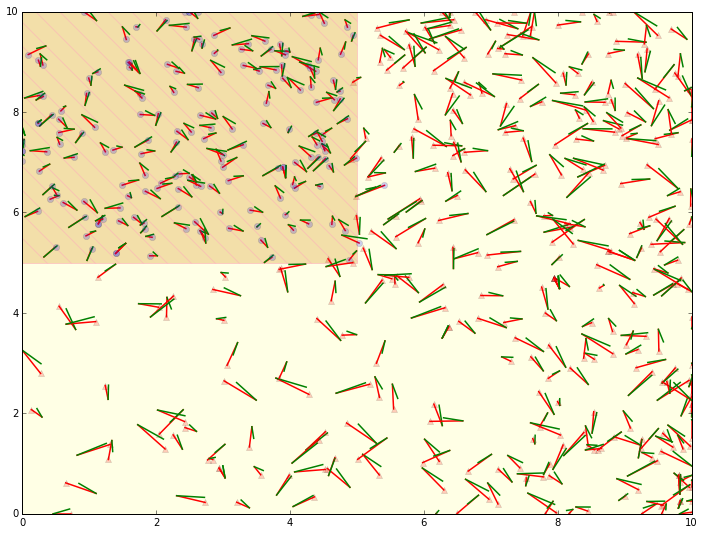

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

def Virtualizing(Data, Label, Pred, Map,Obstacles,Muds,SampleSize):
    sample_index=np.random.choice(len(Data), SampleSize)
    #print sample_index
    #print Train_Data[sample_index,:2],Train_Label[sample_index,:2]
    fig9 = plt.figure(figsize=(12, 9), dpi=100)
    ax9 = fig9.add_subplot(111)
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    patch = PolygonPatch(Map, facecolor='#ffffcc', edgecolor='#ffffcc', alpha=0.5, zorder=2)
    ax9.add_patch(patch)
    MIN=min(Pred[:,2])
    MAX=max(Pred[:,2])
    for i in sample_index:
        plt.plot([Data[i,0],Data[i,0]+Label[i,0]], [Data[i,1],Data[i,1]+Label[i,1]], 'r-',lw=1.5)
        plt.plot([Data[i,0],Data[i,0]+Pred[i,0]], [Data[i,1],Data[i,1]+Pred[i,1]], 'g-',lw=1.5)
        
        #Test Classification Result
        if int(round(Pred[i,2]))==0:
            plt.plot([Data[i,0]+Label[i,0]], [Data[i,1]+Label[i,1]],'r^',alpha=0.2,lw=1.5)
        else:
            plt.plot([Data[i,0]+Label[i,0]], [Data[i,1]+Label[i,1]], 'bo',alpha=0.2,lw=1.5)    
#        plt.scatter([Data[i,0]+Label[i,0]], [Data[i,1]+Label[i,1]],vmin=MIN, vmax=MAX,c=Pred[i],cmap=mpl.cm.get_cmap('hot'))
        #
        
    for obstacle in Obstacles:
        patch = PolygonPatch(obstacle, facecolor='#ffaabb', edgecolor='#ffaabb', alpha=0.2,hatch='\\', zorder=2)
        ax9.add_patch(patch)
    for mud in Muds:
        patch = PolygonPatch(mud, facecolor='#E8C06F', edgecolor='#ffaabb', alpha=0.5,hatch='\\', zorder=2)
        ax9.add_patch(patch)
    plt.show()

Virtualizing(Test_Data,Test_Label,Test_Pred,Maze.maze,Maze.obstacles,Maze.muds,500)

### 2.Weights Extraction Analysis

In [17]:
DNN_DELTA=FullyConnectedDeepNet(6,100,2,4,0.1)
# Train_Data=ReadData(Datapath)
# Train_Label=ReadData(Labelpath)
DNN_DELTA.LoadModel("TransitionModel_DELTA.h5")
for layer in DNN_DELTA.GetModel().layers: 
    g=layer.get_config()
    h=layer.get_weights() 
    print (g) 
    print (h)

TypeError: __init__() takes exactly 6 arguments (5 given)

The weight matrix is input_dim * output_dim, bias is vector with output_dim

The out put format is
target_node_name Activition_function [input_nodel_name weight_target_input]+ ...

We start from the first layer..

### 3. Create New File Layout for MILP

In [18]:
class NetTopology(object):
    def __init__(self,layers,drop_out):
        self.layers=layers
        self.input_dim=layers[0].get_config()[0].get('config').get('input_dim')
        self.num_upper_layers=len(layers)
        self.nodenames=[]
        self.drop_out=drop_out
        layernodename=[]
        for i in range(0, self.input_dim):
            layernodename.append('N0'+str(i))
        layernodename.append('B0')
        self.nodenames.append(layernodename)
        
    def LayerWiseTransform(self,layer,layer_id, lastlayer=False, hiddenstart='N', writefile=False, filehandler=None):
        if not lastlayer:
            input_dim = layer.get_config()[0].get('config').get('input_dim')
            output_dim = layer.get_config()[0].get('config').get('output_dim')
            activation = layer.get_config()[1].get('config').get('activation')
        else:
            input_dim = layer.get_config().get('input_dim')
            output_dim = layer.get_config().get('output_dim')
            activation = layer.get_config().get('activation')
        layernodename=[]
        weights_bias=layer.get_weights()
        weights=weights_bias[0]
        bias=weights_bias[1]
        for i in range(0, output_dim):
            layernodename.append(hiddenstart+str(layer_id)+str(i))
        for i in range(0, output_dim):
            row = [layernodename[i],activation]
            for j in range(0, input_dim):
                row.append(self.nodenames[-1][j])
                row.append(weights[j][i]*self.drop_out)
            row.append(self.nodenames[-1][-1])
            row.append(bias[i])
            if writefile:
                filehandler.write(','.join(map(str, row))+'\n')
            else:
                print ','.join(map(str, row))
        layernodename.append('B'+str(layer_id))
        self.nodenames.append(layernodename)
        
    def NetTransform(self,hiddenstart='N', writefile=False, filepath=None,overwrite=False):
        filehandler=None
        if writefile:
            fullpath=PathFinder(filepath)
            if overwrite is True:
                filehandler = open(fullpath,'w')
            else:
                filehandler = open(fullpath,'a')
        counter=0
        for i in range(0,self.num_upper_layers):
            if type(self.layers[i]) is not Dropout:
                if (i==self.num_upper_layers-1):
                    self.LayerWiseTransform(self.layers[i],counter+1, True, hiddenstart, writefile, filehandler)
                else:
                    self.LayerWiseTransform(self.layers[i],counter+1, False, hiddenstart, writefile, filehandler)
                counter=counter+1
        if writefile:
            filehandler.close()
        print 'Done!'
            
        
        

Topo_DELTA=NetTopology(DNN_DELTA.GetModel().layers,DNN_DELTA.drop_out)
Topo_DELTA.NetTransform('D',True, "Network_MIX.txt",True)
Topo_INJAIL=NetTopology(DNN_INJAIL.GetModel().layers,DNN_INJAIL.drop_out)
Topo_INJAIL.NetTransform('I',True, "Network_MIX.txt",False)
        
    

Done!
Done!


### Notice: 
the output in shape
Output_node_id,Activation_function_name,[Input_node_id, Input_node_weight,]+Bias_id,Bias_weight